In [1]:
import cmath
import math
import typing

from qiskit.circuit.gate import Gate
from qiskit.circuit.library.standard_gates import TGate
from qiskit.opflow import One, OperatorBase, Plus, StateFn, Zero, I
from qiskit.opflow.primitive_ops.primitive_op import PrimitiveOp
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators.operator import Operator
from qiskit.result.counts import Counts
from qiskit.result.result import Result

from dbcquantum.circuit import AQCMeasure, AssertQuantumCircuit
from dbcquantum.utils import eq_state, partial_state

In [2]:
def make_circ_hadamal_test(Ugate: Gate, U: OperatorBase) -> AssertQuantumCircuit:
    size = Ugate.num_qubits + 1
    circ = AssertQuantumCircuit(size)
    circ.h(0)
    circ.append(Ugate.control(), range(size))
    circ.h(0)

    def condition(pre_state: Statevector, post_state: Statevector) -> bool:
        psi = StateFn(partial_state(pre_state, range(1, size)))
        state_0 = (((I+U)@ psi) / 2) ^ Zero  # type: ignore
        state_1 = (((I-U)@ psi) / 2) ^ One  # type: ignore
        return eq_state(post_state, state_0 + state_1)

    circ.add_condition("condition1", condition)
    return circ


In [3]:
# U: OperatorBase = T
U: OperatorBase = PrimitiveOp(Operator([[1, 0], [0, cmath.exp(1j * math.pi / 4)]]))
psi = Plus
Ugate: Gate = TGate()
circ_hadamard_test = make_circ_hadamal_test(Ugate, U)
circ_hadamard_test.run(init_state=psi ^ Zero)

Statevector([7.07106781e-01+0.j  , 2.29934717e-17+0.j  ,
             6.03553391e-01+0.25j, 1.03553391e-01-0.25j],
            dims=(2, 2))


In [4]:
# U: OperatorBase = T
U: OperatorBase = PrimitiveOp(Operator([[1, 0], [0, cmath.exp(1j * math.pi / 4)]]))
psi = Plus
circ = AssertQuantumCircuit(2)
circ.h(1)
circ.append(make_circ_hadamal_test(TGate(), U), [0, 1])

def postprocess(result: Result) -> float:
    counts: Counts = typing.cast(Counts, result.get_counts())
    return (counts["0"] - counts["1"]) / (counts["0"] + counts["1"])

def measure_condition(
    pre_measure_state: Statevector,
    result: Result,
    est_exp: float,
):
    expectd_exp = ((~psi) @ U @ psi).eval().real  # type: ignore
    return cmath.isclose(expectd_exp, est_exp, abs_tol=0.01)

circ_measure: AQCMeasure = AQCMeasure(
    circ, postprocess=postprocess, qubit=[0]
)

circ_measure.add_condition(
    "condition2", measure_condition
)

print(circ_measure.run(shots=100_000))

0.85242


In [5]:
%%timeit -n 1 -r 5
circ_measure.run(shots=100_000)

172 ms ± 7.02 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [6]:
print("#qubits=")
print(circ_measure.num_qubits)
print()
print("#gates=")
print(sum(circ_measure.remove_assertions_to_circuit().count_ops().values()))


#qubits=
2

#gates=
5


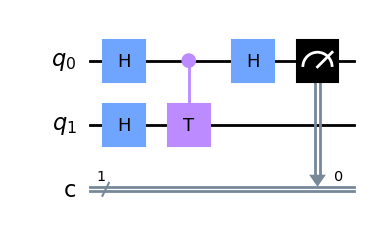

In [7]:
circ_measure.remove_assertions_to_circuit().draw("mpl")